In [1]:
from transformers import TFBertModel, BertTokenizer, AutoTokenizer, TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dropout, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf 
import tensorflow.keras.backend as K
from keras.utils.np_utils import to_categorical

## for data
import pandas as pd
import numpy as np
import re
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

In [ ]:
# !conda install -c conda-forge h5py -y

## Load Data

In [3]:
def read_data(path:str, file_type:str)-> pd.DataFrame:
    if glob.glob(path+file_type+".csv"):
        df = pd.read_csv(path+file_type+".csv")
    
    essay_dict = {}
    for file in glob.glob(path+file_type+'/*.txt'): 
        with open(file, "r") as file_open:
            filename = file.split('train/')[1].split('.txt')[0]
            essay_dict[filename] = file_open.read()
        
    essay_data = pd.DataFrame.from_dict([essay_dict]).T.reset_index()
    essay_data.columns = ["essay_id", "essay_text"]
    train_data = pd.merge(df,essay_data,left_on = 'essay_id', right_on ='essay_id', how ='left')
    print("Train data: ",train_data.shape)
    return train_data

In [4]:
filepath = '/kaggle/input/feedback-prize-effectiveness/'
train_data = read_data(filepath, 'train')
train_data.shape

Train data:  (36765, 6)


(36765, 6)

In [5]:
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfie

In [6]:
def cleanup_text(text):
    words = re.sub(pattern = '[^a-zA-Z]',repl = ' ', string = text)
    words = words.lower()
    return words

def get_len(text):
    return len(text)


train_data['text_preprocessed'] = train_data['discourse_text'].apply(cleanup_text)
train_data['text_len'] = train_data['text_preprocessed'].apply(get_len)
display(train_data.head(2))

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_preprocessed,text_len
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,317
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on M

In [7]:
train_data.discourse_effectiveness.value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 10
BATCH_SIZE = 16
MAX_LEN = 256
MODEL_TYPE="distilbert"

## BERT Encoder

In [ ]:
# text =["Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform."]

# bert_encode(text, tokenizer, distil=True)

In [ ]:
# if MODEL_TYPE=="bert":
#     tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# elif MODEL_TYPE=="distilbert":
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
# # Save the loaded tokenizer locally
# tokenizer.save_pretrained('.')
# sep = tokenizer.sep_token


In [9]:
train_data['inputs'] = train_data.discourse_type + " <SEP> " +train_data.discourse_text
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_preprocessed,text_len,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,317,"Lead <SEP> Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in

In [10]:
bin_map = {"Ineffective": 0, "Adequate": 1, "Effective": 2}
train_data["label"] = train_data["discourse_effectiveness"].map(bin_map)

# categorical_labels = to_categorical(int_labels, num_classes=None)

In [11]:
# train_data["model_input"] = train_data['inputs'] +"##"+train_data['essay_text'] 
train_data.head(1)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_preprocessed,text_len,inputs,label
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,317,"Lead <SEP> Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",1


In [12]:
train_data.label.value_counts()

1    20977
2     9326
0     6462
Name: label, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data['inputs'], train_data['label'], test_size=0.1, random_state=42, stratify=train_data["label"])
print(X_train.shape,X_valid.shape,y_train.shape,y_valid.shape)

(33088,) (3677,) (33088,) (3677,)


## Building a Bert Model

In [15]:
import gc
gc.collect()

100

In [16]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Sequential, layers
import tensorflow_hub as hub

mcp_save = ModelCheckpoint('.ckpt.hdf5', save_best_only=True, monitor="val_f1_score", mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor="val_f1_score", factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
hub_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", output_shape=[512], input_shape=[], dtype=tf.string,trainable=False)

In [17]:
def build_model_bert(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(3, activation='softmax')(clf_output)
    out = Dense(3, activation='relu')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

def cal_recall(y_true, y_pred):
    y_true = tf.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def cal_precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = cal_precision(y_true, y_pred)
    recall = cal_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model_distilbert(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model(input_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(3, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=out)
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=["categorical_accuracy",f1_score])
    
    return model


def build_model_use(hub_layer=hub_layer):
    
    model = Sequential()
    model.add(hub_layer)
    for units in [128, 64, 16]:
        model.add(Dense(units, activation='selu'))
        model.add(Dropout(0.35))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=["categorical_accuracy",f1_score])
    return model

In [19]:
use_model = build_model_use()

In [20]:
use_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

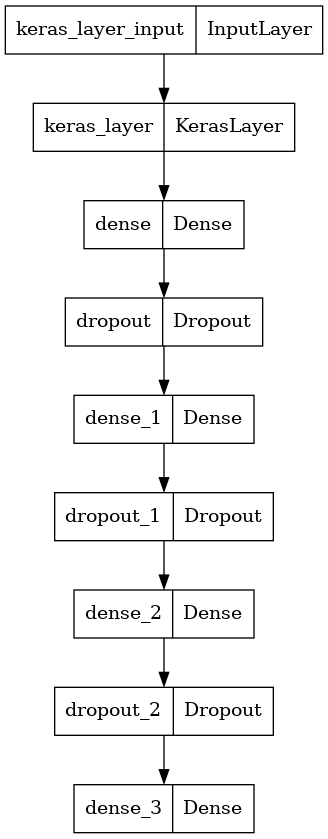

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(use_model)

In [24]:
# train_history = model.fit(
#     train_dataset,
#     steps_per_epoch=100,
#     validation_data=valid_dataset,
#     epochs=5,
#     batch_size = 4048
# )

In [25]:
"""
1 (Adequate)    20977
2 (Effective)    9326
0 (Ineffective)   6462
"""

'\n1 (Adequate)    20977\n2 (Effective)    9326\n0 (Ineffective)   6462\n'

In [42]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight(class_weight = "balanced", classes=np.unique(y_train), y=y_train)

old_class_weights = dict(zip(np.unique(y_train), class_weights_array))
class_weights = {0: 1.2, 1: 0.88, 2: 1.98}
print(old_class_weights, class_weights)

{0: 1.896377808344796, 1: 0.5842117343785864, 2: 1.3141109654871124} {0: 1.2, 1: 0.88, 2: 1.98}


In [46]:
import gc
gc.collect()

46

In [47]:
train_history = use_model.fit(
    x=X_train,
    y=y_train,
    epochs=25,
    batch_size = 256,
    validation_split=.10,
    class_weight=class_weights)

Epoch 1/25
117/117 [==============================] - 10s 86ms/step - loss: 0.9479 - categorical_accuracy: 0.1008 - f1_score: 0.9016 - val_loss: 0.8307 - val_categorical_accuracy: 0.1212 - val_f1_score: 0.9067
Epoch 2/25
117/117 [==============================] - 10s 86ms/step - loss: 0.9477 - categorical_accuracy: 0.1007 - f1_score: 0.9044 - val_loss: 0.8163 - val_categorical_accuracy: 0.1170 - val_f1_score: 0.9061
Epoch 3/25
117/117 [==============================] - 11s 97ms/step - loss: 0.9454 - categorical_accuracy: 0.0994 - f1_score: 0.9065 - val_loss: 0.8330 - val_categorical_accuracy: 0.1197 - val_f1_score: 0.9060
Epoch 4/25
117/117 [==============================] - 10s 83ms/step - loss: 0.9446 - categorical_accuracy: 0.0994 - f1_score: 0.9014 - val_loss: 0.8346 - val_categorical_accuracy: 0.0952 - val_f1_score: 0.9248
Epoch 5/25
117/117 [==============================] - 10s 85ms/step - loss: 0.9475 - categorical_accuracy: 0.1017 - f1_score: 0.9053 - val_loss: 0.8224 - val_ca

## Saving Model

In [61]:
use_model.save('/kaggle/working/use_final.h5')

## Load Model

In [ ]:
# from tensorflow.keras.models import load_model
# import transformers
# use_model = load_model('/kaggle/working/use_test1_0636.h5')

## Validation and Prediction

In [62]:
y_valid_pred = use_model.predict(X_valid, verbose=1)
print(f"Validation Log Loss {log_loss(y_valid, y_valid_pred):.2f}")

115/115 [==============================] - 2s 15ms/step
Validation Log Loss 0.80


In [63]:
result = use_model.evaluate(X_valid, y_valid, verbose=1)

115/115 [==============================] - 2s 14ms/step - loss: 0.8000 - categorical_accuracy: 0.1273 - f1_score: 0.9054


In [64]:
output_df = pd.DataFrame(zip(y_valid, y_valid_pred, y_valid_pred.argmax(1)), columns=["true_label", "predicted_prob","predicted_label"])
bin_map = {0:"Ineffective", 1:"Adequate", 2:"Effective"}
output_df["true_label_class"] = output_df["true_label"].map(bin_map)
output_df["predicted_label_class"] = output_df["predicted_label"].map(bin_map)
output_df.head()

,true_label,predicted_prob,predicted_label,true_label_class,predicted_label_class
0,2,"[0.0030110013, 0.07595071, 0.9210383]",2,Effective,Effective
1,1,"[0.0060420376, 0.13232163, 0.86163634]",2,Adequate,Effective
2,1,"[0.29494727, 0.4789419, 0.22611082]",1,Adequate,Adequate
3,1,"[0.14208849, 0.81774235, 0.0401691]",1,Adequate,Adequate
4,1,"[0.12368091, 0.49077174, 0.3855473]",1,Adequate,Adequate


In [65]:
output_df.groupby(['true_label_class','predicted_label_class'])['true_label'].count()

true_label_class  predicted_label_class
Adequate          Adequate                 1411
                  Effective                 441
                  Ineffective               246
Effective         Adequate                  253
                  Effective                 668
                  Ineffective                12
Ineffective       Adequate                  386
                  Effective                  50
                  Ineffective               210
Name: true_label, dtype: int64

In [66]:
classes = output_df.true_label.unique()
labels = output_df.true_label_class.unique()

In [67]:
valid_predicted = np.zeros_like(y_valid_pred)
valid_predicted[np.arange(len(y_valid_pred)), y_valid_pred.argmax(1)] = 1

In [68]:
# ConfusionMatrixDisplay.from_predictions(y_valid, valid_predicted.argmax(axis =1), display_labels=classes, cmap=plt.cm.Blues)

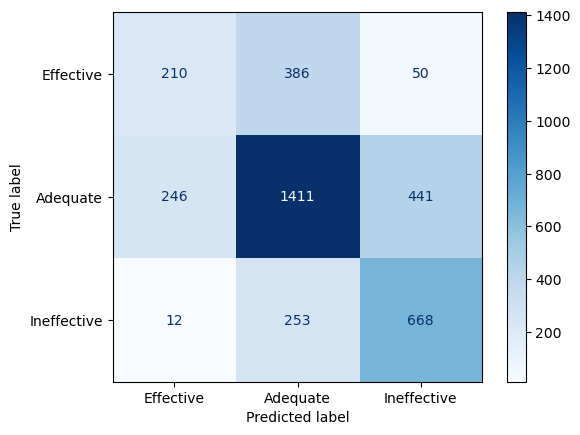

In [69]:
cm = ConfusionMatrixDisplay.from_predictions(y_valid, valid_predicted.argmax(axis =1),\
                                        display_labels=labels, cmap=plt.cm.Blues)

cm.figure_.savefig('/kaggle/working/confusion_matrix_cls1.png')

In [70]:
report = classification_report(output_df['true_label'], output_df['predicted_label'], target_names = labels)
print(report)

              precision    recall  f1-score   support

   Effective       0.45      0.33      0.38       646
    Adequate       0.69      0.67      0.68      2098
 Ineffective       0.58      0.72      0.64       933

    accuracy                           0.62      3677
   macro avg       0.57      0.57      0.57      3677
weighted avg       0.62      0.62      0.62      3677



In [71]:
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    
    class_report_df['avg / total'] = avg

    return class_report_df.T

In [72]:
p_cr = pandas_classification_report(y_true=output_df['true_label'], y_pred=output_df['predicted_label'])
p_cr.to_csv('/kaggle/working/cls1_cr.csv',  sep=',')

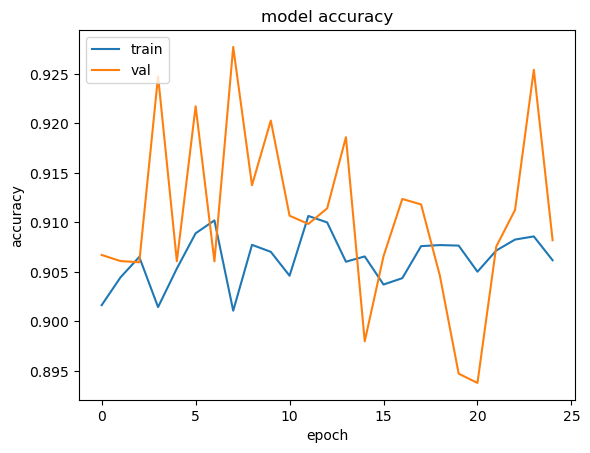

<Figure size 640x480 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt
plt.plot(train_history.history["f1_score"])
plt.plot(train_history.history["val_f1_score"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/kaggle/working/accuracy_cls1.png', bbox_inches='tight')

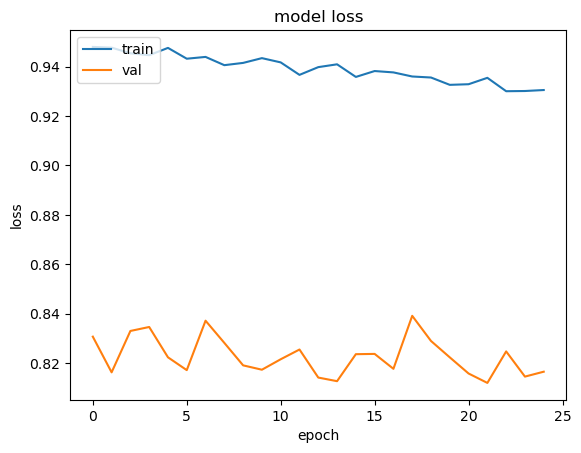

<Figure size 640x480 with 0 Axes>

In [74]:
train_history.history.keys()
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/kaggle/working/loss_cls1.png', bbox_inches='tight')

Ineffective": 0, "Adequate": 1, "Effective": 2

In [75]:
output_df['true_label'].value_counts()

1    2098
2     933
0     646
Name: true_label, dtype: int64

In [76]:
train_data['label'].value_counts()

1    20977
2     9326
0     6462
Name: label, dtype: int64